# Food Delivery Time Prediction Project

Hanjie Jiang, 11/09/2021 - 11/19/2021

# Table of Contents
1. [Overview](#overview)
    1. [From the `Machine_Learning_Data_Science_project_prompt.pdf` file](#requirement)
2. [Business Problem Understanding, Assumptions & Real-life Food Delivery Case Study](#problem)
    1. [Business Problem Understanding](#understanding)
    2. [Model Simplification with Assumptions](#assumption)
    3. [Factors/Features Affecting a Real-Life Food Delivery: Case Study](#case)
3. [Data Browsing & Features in the Dataset](#dataset)
    1. [From the `data_description.txt` file](#explain)
    2. [Features in the Dataset and Correspondence to the Real-life Factors](#factor)
4. [Initial Dataset Processing](#process)
    1. [Package Loading](#package)
    2. [Dataset Importing and Browsing](#browsing)
    3. [Discussion on the Missing Value Treatments](#discuss-treat)
    4. [Missing Value and Negative Value Processing](#missing)
    5. [Feature Engineering & Additional Feature Creation](#creation)
5. [Data Analysis](#analysis)
    1. [Univariate](#univariate)
        1. [Categorical Columns](#categorical)
        2. [Numerical Columns](#numerical)
    2. [Multivariate](#multivariate)
6. [Machine Learning Model](#mlmodel)
    1. [Discussion on Model Selection](#selection)
    2. [Data and Function Preparation for ML Models](#prepare)
    3. [Linear Regression Model](#lrmodel)
    4. [Lasso Regression Model](#lasso)
    5. [Random Forest Model](#randfor)
        1. [Step 1: Hyperparameter Tuning for Random Forest](#hyper_randfor)
        2. [Step 2: Evaluation using the Optimal Random Forest Model](#eval_randfor)
    6. [XGBoost Algorithm](#xgboost)
        1. [Step 1: Hyperparameter Tuning for XGBoost](#hyper_xgboost)
        2. [Step 2: Evaluation using the Optimal XGBoost Model](#eval_xgboost)
    7. [Model Comparison](#model_comp)
7. [Test set prediction](#test_pred)

## Overview <a name="overview"></a>


### From the `Machine_Learning_Data_Science_project_prompt.pdf` file: <a name="requirement"></a>

<font color='grey'>

### Introduction

We require candidates to **meet a high bar** on this assignment to **advance to the final round onsite**, so we would encourage you to demonstrate the full extent of your data science toolkit. We will look at **more than just your performance on the test set**. <br>

In particular, you will be evaluated on the following:<br>
1. The quality of your data science process - **data pre-processing**, **feature engineering**, **model selection**, etc. Please **make sure to show all of your work!**
2. **Your algorithm’s performance on a test set** where labels are withheld, evaluated on expected business impact.
3. The quality & insightfulness of **your written report** (see requirements below).

### Project Description

Before a consumer places an order on DoorDash, we show the **expected delivery time**. It is very important for DoorDash to get this right, as it has a big impact on consumer experience. Order lateness / underprediction of delivery time is of particular concern as past experiments suggest that **underestimating delivery time is roughly twice as costly as overestimating it.** Orders that are **very early / late** are also much worse than those that are only **slightly early / late.** In this exercise, you will build a model to predict the estimated time taken for a delivery.
<br>

Concretely, for a given delivery you must predict the **total delivery duration seconds**, i.e., the time from: 
<br>

● Start: the time consumer submits the order (`created_at`) to<br>
● End: when the order will be delivered to the consumer (`actual_delivery_time`).

<br>
To help with this, we have provided:

<br>
● historical_data.csv: table of historical deliveries (your training set)<br>
● data_to_predict.csv: data for deliveries that you must predict (label-free test set we will use for evaluation)<br>
● data_description.txt: description of all columns in historical_data.csv and details of data_to_predict.csv

### Requirements

1. Build a model to predict the **total delivery duration seconds** (as defined above). You’ll likely find it helpful to **generate additional features from the given data to improve model performance.**
<br>
2. Output predictions on the instances in **data_to_predict.csv** — we will use the results here to evaluate your model
<br>
3. Write a **short report (typically 1-2 pages)** on the **problem, your approach, and results** containing:

    a. A high-level **business summary** explaining the **key results to semi-technical readers**. Include some
    **feature interpretation** and highlight the **model’s performance relative to what is likely feasible**.<br>
    
    b. A list of **3-5 features you believe would improve** model performance if included in the training set.
    Please clearly **articulate the value you believe adding these features would drive** for the business.<br>
    
    c. Assume the model you designed would replace a model already in production. How would you **assess your model’s performance** relative to that of its predecessor **before replacing** the previous model?
    Please do not write about your modeling process - this is covered in the code submission.
    
### Deliverables
1. Your code / **jupyter notebook**
2. Predictions for deliveries in data_to_predict.csv.
    Should contain rows of the form **<delivery_id>,<predicted_duration>**
3. **Your report**
    
</font>

## Business Problem Understanding, Assumptions & Real-life Food Delivery Case Study<a name="problem"></a>

### Business Problem Understanding<a name="understanding"></a>

1. **Machine Learning Problem:** Regression (Continuous target values) predictions
<br>

2. **Objective:** Predicting the estimated **total delivery time (in seconds)** from factors that **DoorDash has control over**. <span style="background-color:#eef0c8">Hence, **the primary quantity of interest that we care about is the amount of time that we need after the customer creates the order up until the order has been delivered**</span>: 
<br>

$
\begin{align}
\text{total delivery time} &= \text{looking-for-dasher time} + \text{driving-to-store time} \\
                            &+ \text{waiting-for-food time} + \text{store-to-customer time} + \text{drop-off time}  \tag{1}
\end{align}
$

### Model Simplification with Assumptions<a name="assumption"></a>

1. Assuming $\text{drop-off time}$ is negligible since more often people will either choose no-contact delivery or leave-at-the-front-door options for simplicity. Even when instructions were not given, when the dasher calls, the customer will direct the dasher to a convenient place for the dasher to leave the delivery at. In other words,  **$\text{drop-off time} = 0$** in the equation (1) above.
<br>

Hence, equation (1) after simplified can be written as:

$
\begin{align}
\text{total delivery time} &= \text{looking-for-dasher time} + \text{driving-to-store time} \\
                            &+ \text{waiting-for-food time} + \text{store-to-customer time} \tag{2}
\end{align}
$

<br>

### Factors/Features Affecting a Real-Life Food Delivery: Case Study<a name="case"></a>

Features that may affect the total food delivery time have to **directly, or indirectly, affect either the looking-for-dasher time, driving-to-store time,waiting-for-food time or store-to-customer time.** Therefore, features/factors are categorized based on the different part of the dashers' journey that they have impacts on:

**Features that may affect <font color='blue'>"looking-for-dasher time"</font>:**
<br>
- Demand (Customer):
    1. **Order time** during the day (morning, noon, afternoon, evening, late night): <font color='red'>needs to change the UTC time to local (Pacific) time</font> <br>
    2. **Which day** of the week (weekdays vs. weekends)<br>
    3. **Which month** of the year (April vs. September, i.e. Sports Seasons)
    4. Whether the customer orders on a **holiday** (Holiday vs. non-holiday)
<br>
- Supply (Dasher):
    1. **How many Dashers On the Road**
    2. **Total Busy Dashers and Total Available Dashers**
    3. **Total Orders that need to be delivered within the Area**

**Features that may affect <font color='blue'>"driving-to-store time"</font>:**
- Distance between the dasher's current location and the store
- Traffic on the route between the dasher's current location and the store

**Features that may affect <font color='blue'>"waiting-for-food time"</font>:**
- Customer:
   1. **Order Size** can be a good indicator of how long it will take the store to prepare the order. If the order size is large enough, we may encounter situations where the dasher may arrive at the store before the food comes out.
<br>
- Store:
   1. **Type of food** the store makes can indicate how fast the food comes out. A pizza store like <em>Domino's</em> or fast food chain like <em>McDonald's</em> is expected to prepare the order much faster than a fine dining place or a steak house.

**Features that may affect <font color='blue'>"store-to-customer time"</font>:**
- Traffic on the route between the store and the customer's place
- Distance between the store and the customer's place

## Data Browsing & Features in the Dataset<a name="dataset"></a>

### From the `data_description.txt` file:<a name="explain"></a>

<font color='grey'>

#### Data description #### 
The attached file `historical_data.csv` contains a subset of deliveries received at DoorDash in **early 2015 in a subset of the cities.** Each row in this file corresponds to one unique delivery. Each column corresponds to a feature as explained below. Note all money (dollar) values given in the data are **in cents** and all time duration values given are **in seconds**.
The target value to predict here is the **total seconds value between `created_at` and `actual_delivery_time`**. 

We have added noise to the dataset to obfuscate certain business details. Both `historical_data.csv` and `predict_data.csv` include similar noise. We will only be evaluating your model's performance on this noisy, artificial dataset. The baseline model we will compare it was also trained and evaluated on the same noisy dataset.

#### Columns in historical_data.csv

### Time features
market_id: A city/region in which DoorDash operates, e.g., Los Angeles, given in the data as an id<br>
created_at: **Timestamp in UTC** when the order was submitted by the consumer to DoorDash. (Note this timestamp is in UTC, but in case you need it, **the actual timezone of the region was US/Pacific**)<br>
actual_delivery_time: **Timestamp in UTC** when the order was delivered to the consumer

### Store features 
store_id: an **id representing the restaurant** the order was submitted for

### Order features
subtotal: **total value** of the order submitted (in cents)

### Market features
DoorDash being a marketplace, we have information on the state of marketplace when the order is placed, that can be used to estimate delivery time. The following features are **values at the time of `created_at` (order submission time)**
<br>
total_onshift_dashers: Number of available dashers who are **within 10 miles of the store** at the time of order creation 
<br> 
total_busy_dashers: **Subset of above `total_onshift_dashers`** who are **currently working** on an order
<br>
total_outstanding_orders: **Number of orders within 10 miles of this order** that are currently being processed.

### Predictions from other models:
We have predictions from other models for various stages of delivery process that we can use.
estimated_store_to_consumer_driving_duration: Estimated travel time between **store and consumer (in seconds)**



#####################################################################################
#### Data to predict #### 
Also attached here is `predict_data.csv`, which provides the new data that you must predict on using the model you build. This data was generated similar to the `historical_data.csv` and it contains the same columns as above, except for the following differences:
  * This file does not contain `actual_delivery_time`, since that is unknown at the time of prediction
  * This file contains `delivery_id` as additional field
Each row of the data is one data point to predict on. Note that `predict_data.csv` contains orders from later weeks compared to `historical_data` 
</font>

### Features in the Dataset and Correspondence to the Real-life Factors<a name="factor"></a>
Actual total delivery time `actual_total_time` (in seconds) can be obtained from the `created_at` and `actual_delivery_time` columns by taking the difference between the two columns. This feature is the most direct and important feature that we use to train the model. 

**Features that may affect <font color='blue'>"looking-for-dasher time"</font>:**
<br>
- Demand (Customer):
    1. `created_at` and `actual_delivery_time` indicate when during the day the order is created, by creating a new feature column `order_time`. <br>
    2. `created_at` and `actual_delivery_time`can also indicate on `which_day_of_week` (weekdays vs. weekends) the order is created <br>
    3. `created_at` and `actual_delivery_time` features determines whether the customer orders on a `holiday` (Holiday vs. non-holiday)
<br>
- Supply (Dasher):
    1. `total_onshift_dashers` provides information on **how many dashers are on the road within the area**
    2. `total_busy_dashers` indicates the number of **Total Busy Dashers and Total Available Dashers**
    3. `total_outstanding_orders` gives information on **Total Orders that need to be delivered within the Area**

**Features that may affect <font color='blue'>"driving-to-store time"</font>:**

Given that the dashers will only be notified if they are **within 10 miles of the store**, the distance between the dasher's current location and store is **relatively fixed**. `market_id`, on the other hand, might be a feature that can be used to **estimate the traffic on the route**, based on how large the market(city) is (`market_scale`), which can further be interpreted from the number of `store_id` within the market. 

- Distance between the dasher's current location and the store
- Traffic on the route between the dasher's current location and the store

**Features that may affect <font color='blue'>"waiting-for-food time"</font>:**
- Customer:
   1. **Order Size** can be effectively interpreted from the `subtotal` feature within the dataset, since in most cases, the more expensive the order is, the more items that the customer orders at a certain store.
<br>
- Store:
   1. **Type of food** that the store makes can be interpreted from **the average `subtotal` per store** that the customers order from a certain store; hence a new column of `average_subtotal_per_store` might be created. When the average `subtotal` is higher, then preparation time is expected to be slower, in most cases. Further investigations are needed on this feature.

**Features that may affect <font color='blue'>"store-to-customer time"</font>:**

`estimated_store_to_consumer_driving_duration` is a direct estimation of the feature; hence, no further deduction is needed towards the store-to-customer time estimates. 

- Traffic on the route between the store and the customer's place
- Distance between the store and the customer's place


<span style="background-color:#eef0c8">**Summarizing the features that need to be added into the dataset, six new columns are needed for better predictions to be made, including `actual_total_time`, `average_subtotal_per_store`, `order_time`, `which_day_of_week`,  `holiday`, `estimated_food_prepare_time` and `market_scale`.**</span>

## Initial Dataset Processing<a name="process"></a>

### Package Loading<a name="package"></a>

In [1]:
# basic libraries/packages for math and data processing
import pandas as pd
import numpy as np
import statistics
import scipy.stats as scs
import scipy.stats as stats
import statsmodels.api as sm
from math import sqrt

# functions within sklearn
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score, KFold, \
                                    GridSearchCV, cross_validate, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, \
                        mean_absolute_percentage_error, confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

# from xgboost
import xgboost as xgb

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 

# time / date libraries
from datetime import datetime, timedelta, date, time
import pytz
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar # check if it is a holiday

### Dataset Importing and Browsing<a name="browsing"></a>

In [2]:
df_train = pd.read_csv('historical_data.csv')
df_test = pd.read_csv('predict_data.csv')

In [3]:
print("train set is of size: ", df_train.shape, "\n")
print("training set has columns: ", df_train.info(), "\n")

train set is of size:  (197428, 9) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 9 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   subtotal                                      197428 non-null  int64  
 5   total_onshift_dashers                         181166 non-null  float64
 6   total_busy_dashers                            181166 non-null  float64
 7   total_outstanding_orders                      181166 non-null  float64
 8   estimated_store_to_consumer_driving_duration  196902 non-null  float64
dtypes: float64(5

In [4]:
print("test set is of size: ", df_test.shape, "\n")
print("test set has columns: ", df_test.info(), "\n")

test set is of size:  (54778, 9) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54778 entries, 0 to 54777
Data columns (total 9 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   market_id                                     54528 non-null  float64
 1   created_at                                    54778 non-null  object 
 2   store_id                                      54778 non-null  int64  
 3   subtotal                                      54778 non-null  int64  
 4   total_onshift_dashers                         50145 non-null  float64
 5   total_busy_dashers                            50145 non-null  float64
 6   total_outstanding_orders                      50145 non-null  float64
 7   estimated_store_to_consumer_driving_duration  54767 non-null  float64
 8   delivery_id                                   54778 non-null  int64  
dtypes: float64(5), int64(3), ob

In [5]:
#check data timeline
print("the training set starts from: ", min(df_train['created_at']), "up until orders created at: ", max(df_train['created_at']))
print("the training set starts from: ", min(df_test['created_at']), "up until orders created at: ", max(df_test['created_at']))

the training set starts from:  2014-10-19 05:24:15 up until orders created at:  2015-02-18 06:00:44
the training set starts from:  2015-02-18 14:50:28 up until orders created at:  2015-02-25 05:59:49


We are trying to use the data from 2014-10-19 to 2015-02-18 to train the models to learn about what might be happening immediately after that. **Since data are given mostly of the same season, hence, we can ignore the effect of ordering in different month of the year.** Therefore, `which_month` column will not be generated anymore.

In [6]:
#check columns in df_train to see if there is any data missing
# txt1 = "My name is {fname}, I'm {age}".format(fname = "John", age = 36)
count_nan = []
for col in df_train.columns:
    count = len(df_train) - df_train[col].count()
    count_nan.append(count)
    percent = float("{:.2f}".format(count/len(df_train)*100))
    print("There are ", count, " (", percent, "%) NaNs in ", col, "column")

There are  987  ( 0.5 %) NaNs in  market_id column
There are  0  ( 0.0 %) NaNs in  created_at column
There are  7  ( 0.0 %) NaNs in  actual_delivery_time column
There are  0  ( 0.0 %) NaNs in  store_id column
There are  0  ( 0.0 %) NaNs in  subtotal column
There are  16262  ( 8.24 %) NaNs in  total_onshift_dashers column
There are  16262  ( 8.24 %) NaNs in  total_busy_dashers column
There are  16262  ( 8.24 %) NaNs in  total_outstanding_orders column
There are  526  ( 0.27 %) NaNs in  estimated_store_to_consumer_driving_duration column


In [7]:
#check columns in df_test to see if there is any data missing

count_nan_test = []
for col in df_test.columns:
    count = len(df_test) - df_test[col].count()
    count_nan_test.append(count)
    percent = float("{:.2f}".format(count/len(df_train)*100))
    print("There are ", count, " (", percent, "%) NaNs in ", col, "column")

There are  250  ( 0.13 %) NaNs in  market_id column
There are  0  ( 0.0 %) NaNs in  created_at column
There are  0  ( 0.0 %) NaNs in  store_id column
There are  0  ( 0.0 %) NaNs in  subtotal column
There are  4633  ( 2.35 %) NaNs in  total_onshift_dashers column
There are  4633  ( 2.35 %) NaNs in  total_busy_dashers column
There are  4633  ( 2.35 %) NaNs in  total_outstanding_orders column
There are  11  ( 0.01 %) NaNs in  estimated_store_to_consumer_driving_duration column
There are  0  ( 0.0 %) NaNs in  delivery_id column


A large number of data is missing in `total_onshift_dashers`, `total_busy_dashers`, `total_outstanding_orders` columns. We need to take a closer look at these three columns to check **if the data is always missing at the same time**:

<AxesSubplot:>

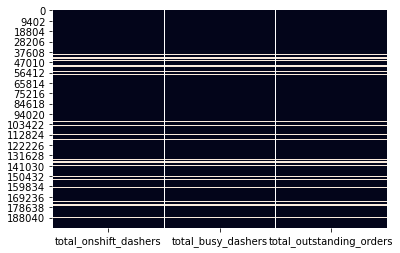

In [8]:
df_dasher = df_train.filter(regex='^total', axis=1)
fig_miss_dasher, ax_miss_dasher = plt.subplots()
#fig_miss_dasher.set_size_inches(18.5, 10.5) 
sns.heatmap(df_dasher.isnull(), cbar=False)

In [9]:
df_or_null = df_dasher[~df_dasher['total_onshift_dashers'].notnull() | ~df_dasher['total_busy_dashers'].notnull() \
                  | ~df_dasher['total_outstanding_orders'].notnull()]
df_all_null = df_dasher[~df_dasher['total_onshift_dashers'].notnull() & ~df_dasher['total_busy_dashers'].notnull() \
                  & ~df_dasher['total_outstanding_orders'].notnull()]

if (len(df_or_null) == len(df_all_null)):
    print("all the dasher-related data are missing at the same time")
else:
    print("some data are not missing at the same time")

all the dasher-related data are missing at the same time


### Discussion on the Missing Value Treatments<a name="discuss-treat"></a>

1. `market_id` column:
    - When other market_id's are given at the same store:
    Some of the market_id values are missing. Missing values in this column can filled up if the same store_id can be found within the same market. **Simple treatments, such as ffill() and bfill(), can be used to process the missing data in this column**.
     
    - When no other market_id is provided at the same store:
    When most of the missing values are filled up, the rest of the data points with missing values are less indicative for learning the trend, since only 1 data point is generated at the store, with no knowledge of where the store locates. Hence, **These values can be dropped**.


2. `created_at` and `actual_delivery_time` columns:

    Since the primary output feature of interest is the `actual_total_time`, which has to be generated based upon the `create_at` and `actual_delivery_time` columns, when there is data missing in the `create_at` and `actual_total_time` column, it is difficult for the model to process and learn. Therefore, **we drop those data points with either of these two columns empty**.


3. `store_id` and `subtotal` columns:

    We don't have any data missing, either in training or testing set, in these two columns. No need to process the data in these two columns.


4. `total_onshift_dashers`, `total_busy_dashers`, `total_outstanding_orders` columns:

    Additional data observations were done to check if the data within these 3 columns are missing at the same time. It is determined that whenever one of the columns has data missing, the other two will have NaN values. However, the missing data of these 3 columns make up ~8% (see the print-outs above) in the training set and ~2% in the test set, therefore it is necessary for us to fill up these missing values. The most simple but effective way is to fill up the values with the **average total_onshift_dashers at same market id and created hour**.
    
5. `estimated_store_to_consumer_driving_duration` column:

    Values from this column are of significant importance to the prediction, $i.e.$, total delivery time, due to the fact that it is a direct estimation of the store-to-consumer time. With 0.27% of the training data and 0.01% test data missing in this column, **we could drop this part of the data but approximately remain at the same level of bias and accuracy.**

### Missing Value and Negative Value Processing<a name="missing"></a>

#### Missing Values

#### `market_id` column

In [10]:
#filling up market_id in the training set based on info from the same store_id 
df_train['market_id'] = df_train.groupby('store_id')['market_id'].apply(lambda x: x.ffill().bfill())
print(df_train[df_train["market_id"].isna()].sort_values(by=["store_id"]))

        market_id           created_at actual_delivery_time  store_id  \
120923        NaN  2015-02-08 03:39:46  2015-02-08 04:25:31      3258   
152850        NaN  2015-02-08 23:43:19  2015-02-09 00:33:20      4122   
186154        NaN  2015-02-15 23:53:45  2015-02-16 00:25:42      5774   

        subtotal  total_onshift_dashers  total_busy_dashers  \
120923      3470                    NaN                 NaN   
152850      3400                    3.0                 3.0   
186154      1550                   14.0                14.0   

        total_outstanding_orders  estimated_store_to_consumer_driving_duration  
120923                       NaN                                         395.0  
152850                       3.0                                         586.0  
186154                      18.0                                         261.0  


In [11]:
df_test['market_id'] = df_test.groupby('store_id')['market_id'].apply(lambda x: x.ffill().bfill())
print(df_test[df_test["market_id"].isna()].sort_values(by=["store_id"]))

       market_id           created_at  store_id  subtotal  \
13320        NaN  2015-02-24 21:48:53        74      2850   
30655        NaN  2015-02-23 01:35:39      1191      4100   
26708        NaN  2015-02-20 03:30:44      2855      6600   
7559         NaN  2015-02-19 19:56:24      4441      4085   
1528         NaN  2015-02-23 02:54:54      5584      2420   
23824        NaN  2015-02-21 03:05:04      6458      6300   

       total_onshift_dashers  total_busy_dashers  total_outstanding_orders  \
13320                   42.0                28.0                      30.0   
30655                    7.0                 5.0                       6.0   
26708                   13.0                13.0                      20.0   
7559                     7.0                 7.0                       7.0   
1528                    35.0                35.0                      43.0   
23824                   29.0                29.0                      43.0   

       estimated_store_to

In [12]:
#only 3 and 6 missing values are left in the training and test set, respectively. Hence, we could drop the data:
df_test = df_test[~df_test["market_id"].isna()]
df_train = df_train[~df_train["market_id"].isna()]

#### `created_at` and `actual_delivery_time` columns

In [13]:
df_train = df_train[~df_train['actual_delivery_time'].isna()]

#### `estimated_store_to_consumer_driving_duration` column

In [14]:
df_test = df_test[~df_test["estimated_store_to_consumer_driving_duration"].isna()]
df_train = df_train[~df_train["estimated_store_to_consumer_driving_duration"].isna()]

#### `total_onshift_dashers`, `total_busy_dashers`, `total_outstanding_orders` columns

To get the same order time information from the dataframe, the `created_at` column and `actual_delivery_time` column needs to be reformatted into datetime objects. Hence, for the sake of performing missing values onto these three dasher-related columns, we need to first perform some simple date-and-time conversions within the next two cells.

#### `order_time` column (Newly Created)

In [15]:
#converting 'created_at' object from object to datetime: 
#https://stackoverflow.com/questions/22800079/converting-time-zone-pandas-dataframe

#converting from UTC to Pacific Time: 
#https://stackoverflow.com/questions/10997577/python-timezone-conversion

#getting rid of the timezone information at the end of the datetime object: 
#https://stackoverflow.com/questions/45085345/remove-timezone-info

# converting 'created_at' and 'actual_delivery_time' in df_train to datetime, then to Pacific Time
date_cols = ['created_at', 'actual_delivery_time']
for t in date_cols:
    df_train[t] = pd.to_datetime(df_train[t], format='%Y-%m-%d %H:%M:%S')
    df_train[t] = df_train[t].dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
    df_train[t] = df_train[t].apply(lambda d: d.replace(tzinfo=None))
    
# converting 'created_at' in df_test to datetime, then to Pacific Time
df_test['created_at'] = pd.to_datetime(df_test['created_at'], format='%Y-%m-%d %H:%M:%S')
df_test['created_at'] = df_test['created_at'].dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
df_test['created_at'] = df_test['created_at'].apply(lambda d: d.replace(tzinfo=None))

#getting the same order_time column ready for estimating the dasher related columns
df_train['order_time'] = df_train['created_at'].dt.hour
df_test['order_time'] = df_test['created_at'].dt.hour

In [16]:
def apply_estimates_dashers(df, colname):
    df[colname] = df.groupby(["market_id",'order_time'])[colname].transform(lambda x: x.fillna(x.mean()))
    return df

In [17]:
for col in df_dasher.columns:
    df_train = apply_estimates_dashers(df_train, col)
    
print(df_train[df_train["total_onshift_dashers"].isna()].sort_values(by=["store_id"]))

        market_id          created_at actual_delivery_time  store_id  \
183750        6.0 2015-02-13 23:00:55  2015-02-14 00:05:11      2215   
176119        6.0 2015-02-07 23:00:22  2015-02-07 23:51:00      5285   

        subtotal  total_onshift_dashers  total_busy_dashers  \
183750      2885                    NaN                 NaN   
176119       800                    NaN                 NaN   

        total_outstanding_orders  \
183750                       NaN   
176119                       NaN   

        estimated_store_to_consumer_driving_duration  order_time  
183750                                         949.0          23  
176119                                         888.0          23  


In [18]:
for col in df_dasher.columns:
    df_test = apply_estimates_dashers(df_test, col)
    
print(df_test[df_test["total_onshift_dashers"].isna()].sort_values(by=["store_id"]))

       market_id          created_at  store_id  subtotal  \
49807        6.0 2015-02-18 07:52:00      1779      1595   
3651         6.0 2015-02-24 07:21:55      1894       745   
44617        6.0 2015-02-19 07:54:18      2489       850   
36751        6.0 2015-02-20 07:59:33      3583      2860   

       total_onshift_dashers  total_busy_dashers  total_outstanding_orders  \
49807                    NaN                 NaN                       NaN   
3651                     NaN                 NaN                       NaN   
44617                    NaN                 NaN                       NaN   
36751                    NaN                 NaN                       NaN   

       estimated_store_to_consumer_driving_duration  delivery_id  order_time  
49807                                         123.0       237740           7  
3651                                          439.0        20840           7  
44617                                         169.0       190005       

From the data filling process described above, we can see that no matter whether it is in the training or test set, we **do not have any information on how many dashers are busy or onshift at 11:00PMish in market 6**. Hence, we will need to get rid of these data points to prevent further data contamination.

In [19]:
df_test = df_test[~df_test["total_onshift_dashers"].isna()]
df_train = df_train[~df_train["total_onshift_dashers"].isna()]

In [20]:
print("df_train set after missing value processing step has ", df_train.shape)
print("df_test set after missing value processing step has ", df_test.shape)

df_train set after missing value processing step has  (196890, 10)
df_test set after missing value processing step has  (54757, 10)


#### Negative Value Processing

In [21]:
df_train.describe()

,market_id,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,order_time
count,196890.000000,196890.000000,196890.000000,196890.000000,196890.000000,196890.000000,196890.000000,196890.000000
mean,2.978379,3530.344025,2682.908131,44.715371,41.675156,58.008883,545.355300,16.118457
std,1.524655,2053.507412,1822.781977,33.653605,31.303105,51.393407,219.352299,3.302610
min,1.000000,1.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000
25%,2.000000,1686.000000,1400.000000,18.000000,16.000000,18.000000,382.000000,13.000000
50%,3.000000,3591.000000,2200.000000,37.000000,35.000000,42.000000,544.000000,17.000000
75%,4.000000,5299.000000,3396.000000,65.362832,61.000000,87.000000,702.000000,19.000000
max,6.000000,6987.000000,27100.000000,171.000000,154.000000,285.000000,2088.000000,23.000000


In [22]:
df_test.describe()

,market_id,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,delivery_id,order_time
count,54757.000000,54757.000000,54757.000000,54757.000000,54757.000000,54757.000000,54757.000000,54757.000000,54757.000000
mean,3.031010,3489.788301,2715.644283,48.923507,43.391516,62.361672,547.805797,126116.258780,16.054788
std,1.531855,2050.193124,1897.858187,36.552107,33.080100,54.751299,220.449251,72681.256909,3.290703
min,1.000000,2.000000,0.000000,-1.000000,-4.000000,-9.000000,0.000000,20.000000,6.000000
25%,2.000000,1661.000000,1420.000000,20.000000,17.000000,20.000000,385.000000,62949.000000,13.000000
50%,3.000000,3518.000000,2220.000000,40.400000,36.000000,46.363636,544.000000,126195.000000,17.000000
75%,4.000000,5248.000000,3414.000000,69.555556,63.000000,89.638889,703.000000,188910.000000,19.000000
max,6.000000,6986.000000,29925.000000,175.000000,169.000000,292.000000,1550.000000,252031.000000,23.000000


While reading the statistical analysis of our training and test dataset, we could see that there is no peculiar outlier seen on the higher end (maximum values). On the lower end, however, only `total_onshift_dashers`, `total_busy_dashers`, `total_outstanding_orders` columns now have negative values that are not making so much sense, based on the minimum description row in the table above. Hence, **creating subtables that containing only the negative values** listed in these columns will help us making better sense of whether the data is mistakenly reported or missing.

Another thing to note in our dataset is that, <span style="background-color:#eef0c8"> **`total_busy_dashers` is a subset of the `total_onshift_dashers`**, which means that **the value in `total_busy_dashers` should always be smaller than `total_onshift_dashers`**. Hence, we will handle both the negative values in the columns and unreasonable data within this section.</span>

#### Step 1: Setting the negative numbers to zero

In [23]:
df_train.loc[df_train.total_onshift_dashers < 0, 'total_onshift_dashers'] = 0
df_train.loc[df_train.total_busy_dashers < 0, 'total_busy_dashers'] = 0
df_train.loc[df_train.total_outstanding_orders < 0, 'total_outstanding_orders'] = 0
df_test.loc[df_test.total_onshift_dashers < 0, 'total_onshift_dashers'] = 0
df_test.loc[df_test.total_busy_dashers < 0, 'total_busy_dashers'] = 0
df_test.loc[df_test.total_outstanding_orders < 0, 'total_outstanding_orders'] = 0

#### Step 2: Setting `total_onshift_dashers` to be larger than `total_busy_dashers`

In [24]:
df_train.loc[df_train.total_onshift_dashers < df_train.total_busy_dashers, 'total_onshift_dashers'] = df_train['total_busy_dashers']
df_test.loc[df_test.total_onshift_dashers < df_test.total_busy_dashers, 'total_onshift_dashers'] = df_test['total_busy_dashers']

### Feature Engineering & Additional Feature Creation<a name="creation"></a>

#### `which_day_of_week` column

In [25]:
df_train['which_day_of_week'] = df_train['created_at'].dt.dayofweek
df_test['which_day_of_week'] = df_test['created_at'].dt.dayofweek
#print(df_train['which_day_of_week'].unique())

# Monday is denoted as 0 and Sunday, the last day of the week, is denoted as 6

#### `holiday` column

In [26]:
def holiday_column(df):
    cal = calendar()
    holidays = cal.holidays(start=df['created_at'].min(),
                            end=df['created_at'].max()).to_pydatetime()
    df['holiday'] = df['created_at'].dt.date.astype('datetime64').isin(holidays)
    return df
df_train = holiday_column(df_train)
df_test = holiday_column(df_test)

#### `average_subtotal_per_store` column

In [27]:
def avg_subtotal(group):
    group["average_subtotal_per_store"] = np.nanmean(group["subtotal"])
    return group
df_train = df_train.groupby("store_id").apply(avg_subtotal)
df_test = df_test.groupby("store_id").apply(avg_subtotal)

#### `market_scale` column

In [28]:
def market_scale(group):
    group["market_scale"] = len(group["store_id"].value_counts())
    return group
df_train = df_train.groupby("market_id").apply(market_scale)
df_test = df_test.groupby("market_id").apply(market_scale)

#### `actual_total_time` column

In [29]:
# The most important column that we need to determine is how long each order takes to be delivered to the customer
df_train['actual_total_time'] = (df_train['actual_delivery_time'] - df_train['created_at']).dt.total_seconds()

# dropping those deliveries that is longer than 1 day(24 hours=1,440 mins=86,400 secs); 
# probably did not complete or cancelled
df_train = df_train[df_train["actual_total_time"] <= 86400]

## Data Analysis<a name="analysis"></a>

### Univariate<a name="univariate"></a>

We care the most about **how each variable will have an impact on the `actual_total_time`** of the orders. Hence, first thing first, we take a closer look at how each of the categorical columns varies with respect to the total delivery time:

#### Categorical Columns<a name="categorical"></a>

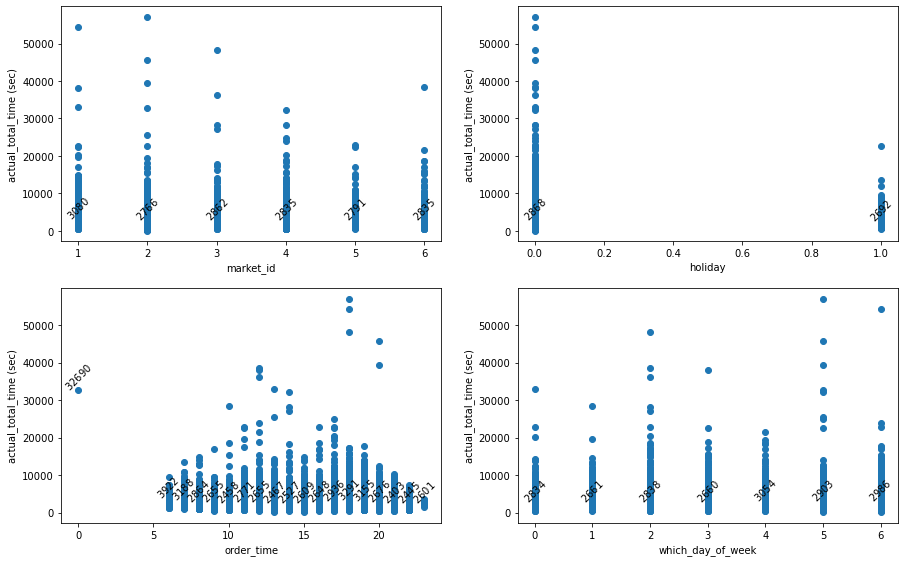

In [30]:
fig1, ax1 = plt.subplots(2, 2)
cat_cols = ["market_id", "holiday", "order_time", "which_day_of_week"]

for i, c in enumerate(cat_cols): 
    y = df_train.groupby(c)["actual_total_time"].apply(lambda x: np.mean(x))
    ylist = y.to_list()
 
    ax1 = ax1.flatten()
    ax1[i].scatter(df_train[c], df_train["actual_total_time"])
    
    for j, txt in enumerate(y):
        ax1[i].annotate(r'${:2.0f}$'.format(txt),(y.index[j], ylist[j]),ha='center',rotation=45)
        
    ax1[i].set_xlabel(c)
    fig1.set_size_inches(15, 9.5)
    ax1[i].set_ylabel("actual_total_time (sec)")

#### `market_id` vs `actual_total_time`
Regardless of how big / busy each market scale is, market with ID 2, 4, 5, and 6 tend to have orders delivered faster than market 1, 3, based on the average actual delivery time that we obtained on the plot. From these "naive" scatter plot, it seems that deliveries from various market_id will definitely expect to have different total_delivery_time. Hence, we can expect the **`actual_total_time` to be influenced by the `market_id` in the our model**. The average total delivery time can be affected by the **# of available dasher within the market, or the # of orders created in the market**, which we may have to further dig into.

#### `holiday` vs `actual_total_time`
Even though we may expect the orders coming from the non-holidays to have much larger size than the orders coming from holidays, based on the scatter plot, we can still expect **at least a weak relationship between whether the order comes in on a holiday and the total delivery time**. It is clearly portraited in plot that the orders on non-holidays can range up to 50,000 seconds, where the orders on holidays are mostly delivered within 30,000 seconds, with an average on holiday increasing by ~200 seconds. This might be due to the **less order created** on holidays, which will potentially be a significant factor that we need to consider.

#### `order_time` vs `actual_total_time`
The first thing we could see from the scatter plot between `order_time` and `actual_total_time` is that there is **no orders made between 1AM - 6AM**, which may be due to that there are not so many restaurants open around that time. Therefore, **we might not be able to learn the trend if new orders are made within this period of time**. Orders created **between 10AM - 14PM and 18PM, 20PM are tend to take longer time** than orders created during other time slots, which may be attributed to 1) the large amount of orders that the restaurants have to process during the peak hours or 2) the heavy traffic on the road at rush hour. 

#### `which_day_of_week` vs `actual_total_time`
From the scatter plot we could see that orders **created on Mondays, Wednesdays, Fridays, Saturdays and Sundays are expected to have longer delivery time than orders from other weekdays**. Hence, this feature is also expected to impact our final prediction.

2.0    55185
4.0    47703
1.0    38128
3.0    23362
5.0    18043
6.0    14466
Name: market_id, dtype: int64
<-------------------------------->
False    190717
True       6170
Name: holiday, dtype: int64
<-------------------------------->
18    36924
17    28175
19    27039
12    15414
20    15242
11    13394
16    12667
13    11406
14     8818
15     8155
21     7094
10     5063
9      3397
8      2098
22     1416
7       536
6        39
23        9
0         1
Name: order_time, dtype: int64
<-------------------------------->
4    33089
5    32836
6    30618
3    26694
2    25138
0    24584
1    23928
Name: which_day_of_week, dtype: int64
<-------------------------------->


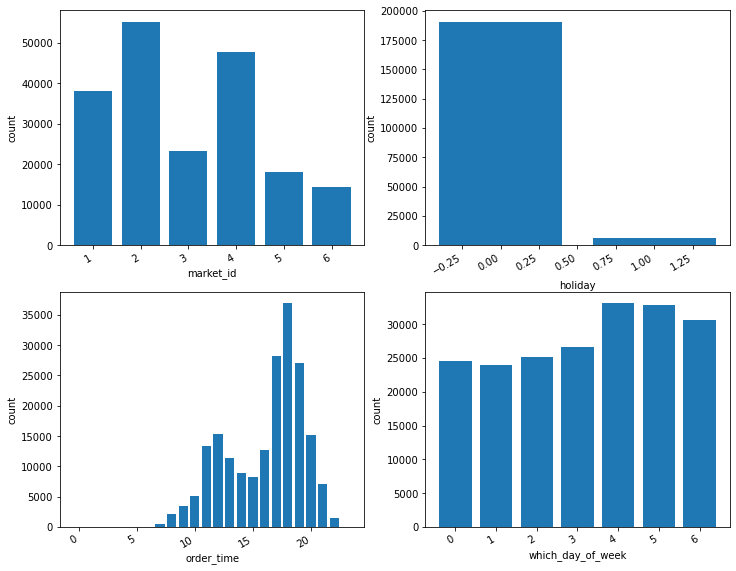

In [31]:
fig2, ax2 = plt.subplots(2,2)
for i, c in enumerate(cat_cols):
    df_cat = df_train[c].value_counts().to_frame().reset_index()
    df_cat.columns = [c,"count"]
    ax2 = ax2.flatten()
    ax2[i].bar(x = df_cat[c], height = df_cat["count"])
    plt.setp(ax2[i].get_xticklabels(), rotation=30, horizontalalignment='right')
    ax2[i].set_xlabel(c)
    ax2[i].set_ylabel("count")
    fig2.set_size_inches(12, 9.5)
    print(df_train[c].value_counts())
    print("<-------------------------------->")

#### `market_id` vs `number_of_orders_created`
Based on the total count of how many orders are created within each market, **market 2 and 4 have the largest potential and size**, then market 1. Market 3, 5, 6 on the other hand are smaller in scale. Nevertheless, from the previous plot, we can see that **market 1 has the slowest average delivery speed**, although it is of huge market size. Therefore, further investigations on the number of dashers within the area are needed to determine if it is correlated to the predictions (actual_delivery_time) that we are trying to make.

#### `holiday` vs `number_of_orders_created`
Orders that are created on holidays are much less in quantities than they are on non-holidays. This can actually be the reason why orders on holidays could be delivered on a faster average delivery time. 

#### `order_time` vs `number_of_orders_created`
Most of the orders are created in the evening, at around 17 - 20PM. Surprisingly, **orders that are created at noon are much less than the orders created at the dinner time, almost half of that**. From the order_time vs total_order_time plots above, it is clear that orders in the evening result in slower average speed than those ones at noon. Hence, a clear relation between the order_time and the actual_delivery_time can be deducted.

#### `which_day_of_week` vs `number_of_orders_created`
Not so surprisingly, more orders come from Fridays, Saturdays and Sundays. In the first place, **a relationship between on which day of the week the order is created and the delivery time can be established**. However, what it says from the previous scatter plot is that orders from Mondays and Wednesdays also have long delivery time. Hence, this should be digged into by looking at the number of dashers onshift during the weekdays. 

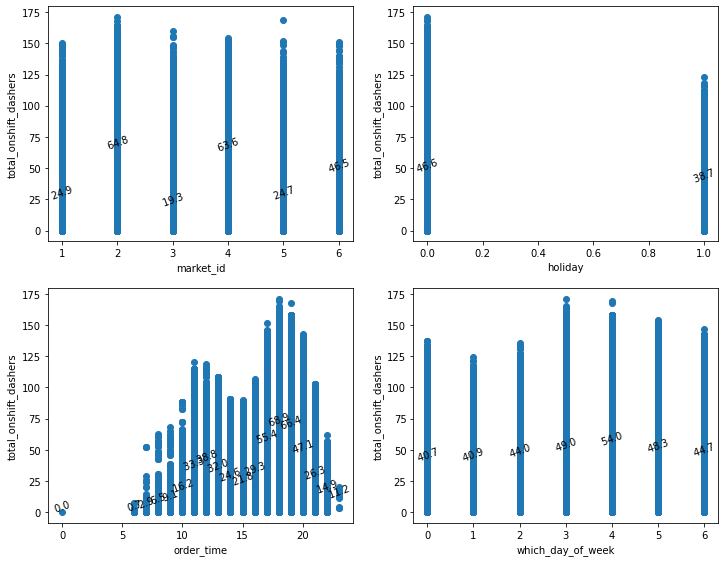

In [32]:
fig3, ax3 = plt.subplots(2,2)

for i, c in enumerate(cat_cols): 
    y = df_train.groupby(c)["total_onshift_dashers"].apply(lambda x: np.mean(x))
    ylist = y.to_list()
    
    ax3 = ax3.flatten()
    ax3[i].scatter(df_train[c], df_train["total_onshift_dashers"])

    for j, txt in enumerate(y):
        ax3[i].annotate(r'${:.1f}$'.format(txt),(y.index[j], ylist[j]),ha='center',rotation=20)

    ax3[i].set_xlabel(c)
    fig3.set_size_inches(12, 9.5)
    ax3[i].set_ylabel("total_onshift_dashers")

#### `market_id` vs `total_onshift_dashers`
The reason why **market 1 has the slowest delivery speed**, which can be seen from the plot above, is that **it on average has a smaller number of dashers available**, when comparing to other large markets. 

#### `holiday` vs `total_onshift_dashers`
Although from the `holiday` vs `number of orders` plot we saw that orders that are created on holidays are much less in quantities than they are on non-holidays. The average `total_onshift_dashers` is not decreasing by that much. Hence, these two factors combined might result in a faster average delivery time on holidays. 

#### `order_time` vs `total_onshift_dashers`
As expected, there are only half as many dashers at noon as there are in the evening. Nevertheless, when comparing to the total order counts, where only 40%ish of the orders are created at noon, comparing to the total counts in the evenings, it results clearly in a faster delivery speed at noon (although the amount of traffic on the road might also be a reason). 

#### `which_day_of_week` vs `total_onshift_dashers`
It is not surprising to see that on Mondays and Wednesdays, there are not so many dashers onshift; hence, these two factors will clearly have an impact on our final predictions of the total delivery time.

#### Numerical Columns<a name="numerical"></a>

Similarly, we first start with browsing the relationship between each of the columns with the feature that we care most about, $i.e.$, `actual_total_time`. Using the regression plot function from seaborn library, it is possible to take a glance of the data:

subtotal   vs actual_total_time: 
r_value = 0.2042
std_err = 0.0014


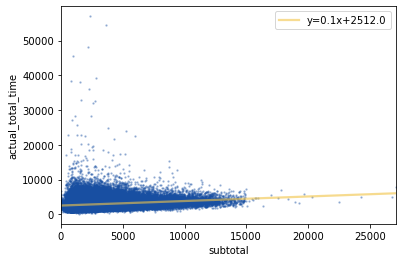

total_onshift_dashers   vs actual_total_time: 
r_value = 0.0649
std_err = 0.0760


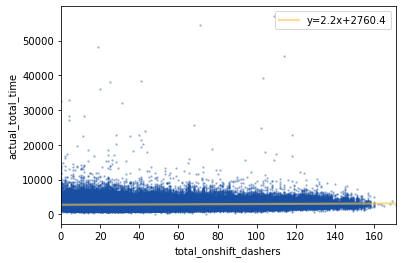

total_busy_dashers   vs actual_total_time: 
r_value = 0.0894
std_err = 0.0835


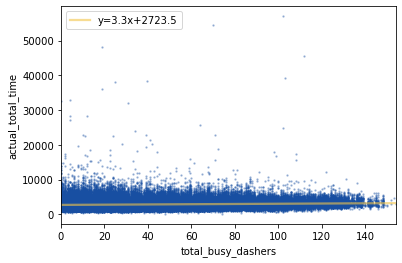

total_outstanding_orders   vs actual_total_time: 
r_value = 0.1723
std_err = 0.0503


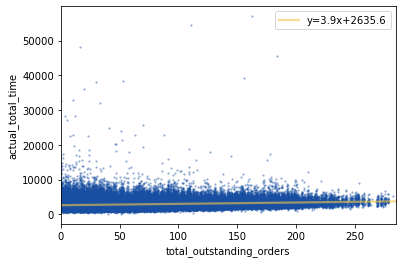

In [33]:
num_cols = ['subtotal', 'total_onshift_dashers','total_busy_dashers','total_outstanding_orders']
for i in (num_cols):
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_train[i],df_train["actual_total_time"])
    fig5, ax5 = plt.subplots()
    regplt = sns.regplot(x=i,y="actual_total_time", data=df_train, \
                         scatter_kws = {'color': '#184fa2', 'alpha': 0.3, 's': 2}, \
                         line_kws = {'color': '#f2c54a', 'alpha': 0.6,\
                                     'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
    ax5.legend()
    print(i, "  vs actual_total_time: ")
    print("r_value = {0:.4f}".format(r_value))
    print("std_err = {0:.4f}".format(std_err))
    plt.show()

#### `subtotal` vs `actual_total_time`
Although a few significant outliers are displayed in the plot, it is still noticable that there is a linear relationship between the `subtotal` vs `actual_total_time`, indicating that the food preparation phase has an impact on the overall order completion.

#### `total_onshift_dashers`, `total_busy_dashers`, `total_outstanding_orders` vs `actual_total_time`
Based on what the scatter plots tell, although not clear enough at this point, we could still recognize an overall trend that when there a larger number of dashers on the road and a larger amount of outstanding orders within the area, **indicating a larger market size and higher demand in the market, the lower limit of the actual delivery time increases**. Nevertheless, the higher limit of the delivery time also decreases, which might seem to be counter-intuitive. This fact might be resulted from a smaller population of data points that represent this extreme (when `total_onshift_dashers`, `total_busy_dashers`, `total_outstanding_orders` reside on the higher end).

From a numerical point of view, **the $R^2$ values and standard deviations of the `subtotal` and `total_outstanding_orders` columns indicate that these two features have higher correlations than the other two. However, the conclusion should not be immediately drawn until the data is more carefully scrutinized.**

To check out the how these columns distribute, **we again calculate the total count of each column:**

Text(0.5, 1.0, 'actual_total_time')

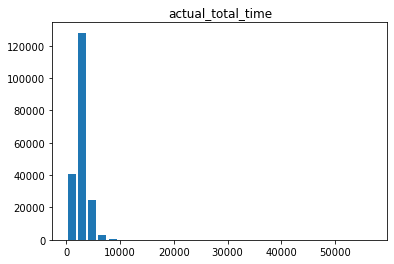

In [34]:
fig6, ax6 = plt.subplots()
ax6.hist(df_train["actual_total_time"],bins=30,rwidth=0.8)
ax6.set_title("actual_total_time")

#### `actual_total_time` vs total_counts
From this bar plot, it is obvious to see that the `actual_total_time` ranges from 0 - 50,000 seconds, most of the data points are less spread out and concentrated near the lower limit (0 - 10,000 seconds). Hence, we could see that the features that have stronger correlation with our final feature of prediction should exhibit similar distributions with that most of the data points locating near the lower limit.

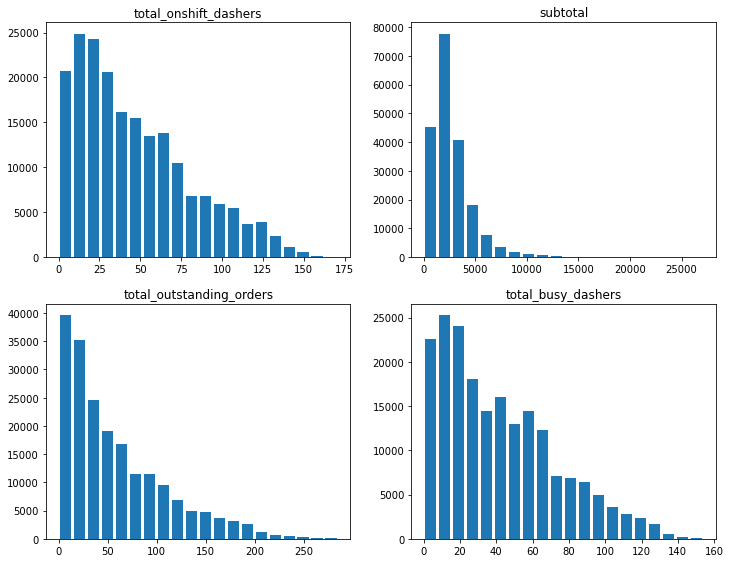

In [35]:
#check Numerical variables distribution (each columns vs. the total count)
fig4, ax4 = plt.subplots(2, 2, figsize=(12, 9.5))
for i,n in enumerate(num_cols):
    ax4[i//2][(i%2)-1].hist(df_train[n],bins=20,rwidth=0.8)
    ax4[i//2][(i%2)-1].set_title(n)

#### `total_onshift_dashers` and `total_busy_dashers` vs total_counts
From what the bar plot depicts, these two features are more widely spread out in range. This might be the reason why the correlation between these two columns are weaker than `total_outstanding_orders` and `subtotal`, since the other two are more concentrated on the lower end of the bar plots. Hence, it is harder to compute the direct relationship between these two features with the `actual_total_time`.

#### `subtotal` and `total_outstanding_orders` vs total_counts
As stated above, these two features have more similar distributions to the `actual_total_time` column, which is the final prediction that we need to make. Therefore, **stronger correlations between `subtotal`, `total_outstanding_orders` and `actual_total_time` could be expected during our modeling process**.

### Correlations (Multivariate)<a name="multivariate"></a>

In [36]:
corr = np.abs(df_train.corr())

In [37]:
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr.style
 .background_gradient(cmap='coolwarm', axis=None, vmin=0, vmax=0.6)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

,market_id,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,order_time,which_day_of_week,holiday,average_subtotal_per_store,market_scale,actual_total_time
market_id,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
store_id,0.02,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
subtotal,0.02,0.01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
total_onshift_dashers,0.06,0.02,0.13,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
total_busy_dashers,0.06,0.02,0.12,0.97,nan,nan,nan,nan,nan,nan,nan,nan,nan
total_outstanding_orders,0.06,0.02,0.13,0.92,0.93,nan,nan,nan,nan,nan,nan,nan,nan
estimated_store_to_consumer_driving_duration,0.01,0.00,0.03,0.04,0.04,0.04,nan,nan,nan,nan,nan,nan,nan
order_time,0.03,0.01,0.12,0.34,0.34,0.34,0.01,nan,nan,nan,nan,nan,nan
which_day_of_week,0.01,0.00,0.04,0.07,0.08,0.08,0.01,0.01,nan,nan,nan,nan,nan
holiday,0.01,0.00,0.02,0.04,0.05,0.05,0.00,0.01,0.29,nan,nan,nan,nan


#### Discussion on correlation between features and `actual_total_time`

By intentionally making `actual_total_time` as the last column in our feature matrix, we can have a clearer view on how this feature is impacted by all the other features that we determined that might be influencing the delivery time. 

| Strong Impact (> 0.1)                                  | Medium Impact (0.05 - 0.1)     | Low Impact (< 0.05) |
| :---:                                                   |    :----:                      |           :---:      |
| subtotal                                               | market_id                    | store_id	       |
| total_outstanding_orders                               | total_onshift_dashers        | holiday           |
| estimated_store_to_consumer_driving_duration         | total_busy_dashers	         |                     |
| order_time                                           | which_day_of_week            |                     |
| average_subtotal_per_store	                        | market_scale	             |                     |

Now, **we have made sense of most of the data in the data set. Hence, we are finally ready to start building new models with the current data we have in hand.**

## Machine Learning Model<a name="mlmodel"></a>

### Discussion on Model Selection<a name="selection"></a>
The overall business problem has already been defined clearly in the earlier sections. We wanted to predict the **total delivery time in seconds** as accurately as one could get to, which is a continuous value that could be better modeled in a regression problem. Hence, we will be selecting those ML models that are more well-known to treat the regression problems, including:
- A simple linear regression to check out the basic feature importance,
- A Lasso regression that helps stabilize the linear model,
- A random forest approach that uses ensemble learning method for regression,
- A XGboost algorithm that provides a regularizing gradient boosting framework.

### Data and Function Preparation for ML Models<a name="prepare"></a>

In [38]:
actual_feature = [col for col in df_train.columns if 'actual' in col]
noactual = df_train.loc[:, ~df_train.columns.isin(actual_feature)]
infeature = noactual.loc[:, noactual.columns != "created_at"]
y=df_train['actual_total_time'].astype('int64')

In [39]:
#error functions that are used for better printing

def run_error_result(actual,forecast,name):
    result_mae = 0 
    result_mape = 0
    for a,f in zip(actual,forecast):
        result_mae += abs(a-f)
        result_mape += abs(a-f)/a
    mae = result_mae/len(forecast)
    mape = result_mape/len(forecast)

    rmse = np.sqrt(mean_squared_error(actual, forecast))
    
    return pd.DataFrame({'MAE':[mae],'MAPE': [mape],'RMSE': [rmse]},index=pd.Series([name]))

In [40]:
#a simple print function that handles printings in sklearn 

def print_sklearn(model, X_train, y_train, X_test, y_test, y_pred, cv_scores):
    print("ML Library: ")
    print("\n Training -------------------\n")
    print(" R2 value(training): {:.3f}".format(model.score(X_train, y_train)))
    print("\n Cross validation scores:")
    print(" R2 (training) values:")
    print(cv_scores["train_r2"])
    print(" neg-mean-absolute-error (training) values:")
    print(cv_scores["train_neg_mean_absolute_error"])
    print("------------------------------------\n")
    print("\n Testing -------------------\n")
    print(" R2 value(testing): {:.3f}".format(model.score(X_test, y_test)))
    print("\n Cross validation scores:")
    print(' R2 (testing) values:')
    print(cv_scores["test_r2"])
    print(" neg-mean-absolute-error (testing) values:")
    print(cv_scores["test_neg_mean_absolute_error"])
    print(' Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
    print(' Root Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred, squared = False))
    print(' Mean absolute error %.2f'
      % mean_absolute_error(y_test, y_pred))
    print(' Mean absolute percentage error %.2f'
      % mean_absolute_percentage_error(y_test, y_pred))
    print("------------------------------------\n")
    return 0

In [41]:
def early_or_late(y_pred, y_test, model_name):
    df_pred = pd.DataFrame(y_test)
    string_name = model_name + '_prediction_accuracy'
    df_pred["pred_total_time"] = y_pred
    df_pred["diff_total_time"] = (y_pred - y_test)
    conditions = [
        (df_pred['diff_total_time'] < -600),
        (df_pred['diff_total_time'] >= -600) & (df_pred['diff_total_time'] < 0),
        (df_pred['diff_total_time'] == 0),
        (df_pred['diff_total_time'] > 0) & (df_pred['diff_total_time'] < 600),
        (df_pred['diff_total_time'] > 600)
    ]
    values = ['very early', 'slightly early', 'on time', 'slightly late', 'very late']
    df_pred[string_name] = np.select(conditions, values)
    
    #count and print out the percentage at each accuracy level
    df_count = df_pred[string_name].value_counts()/len(df_pred)*100
    print(df_pred[string_name].value_counts()/len(df_pred)*100)
    print("<-------------------------------->")
    
    return df_count

### Linear Regression Model<a name="lrmodel"></a>
For the purpose of gradually learning the data, we **start with the most efficient but universally used model, aka the linear regression model, to check out the basic properties of the features** that we included in the model.

In [42]:
def delivery_lr(X, y):
    #Defining the scoring metrics
    scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error']
    
    #Data partitioning into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40,random_state=0)  
    #fit LR model
    model = LinearRegression().fit(X_train, y_train)  
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)
    cv_scores = cross_validate(model, X, y, scoring=scoring,
                         cv=cv, return_train_score=True)
    y_pred = model.predict(X_test)

    print_sklearn(model, X_train, y_train, X_test, y_test, y_pred, cv_scores)
    
    print("\n Feature Importances: ---------- ")
    r = permutation_importance(model, X_train, y_train,n_repeats=15,\
                               random_state=0)
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"    {X_train.columns[i]:<15}"\
                   f"   {r.importances_mean[i]:.3f}"\
                   f" +/- {r.importances_std[i]:.3f}")
        else:
            print("Negative importance:")
            print(f"    {X_train.columns[i]:<15}"\
                   f"   {r.importances_mean[i]:.3f}"\
                   f" +/- {r.importances_std[i]:.3f}")            
    
    print("\n")
    
    print("StatsModels Info: \n")
    # with statsmodels
    x_train = sm.add_constant(X_train) # adding a constant
    x_test = sm.add_constant(X_test) # adding a constant
    
    model_sm = sm.OLS(y_train.astype(float), X_train.astype(float)).fit()
    print(model_sm.summary())

    ## predict train set  (in-sample)
    in_forecast = model_sm.predict(X_train)
    
    print("\n Error Data:")
    print(run_error_result(y_test, y_pred,'Test data'))
    print(run_error_result(y_train, in_forecast,'Training data'))
    return y_pred, y_test

In [43]:
%%time
y_pred_lr, y_test_lr = delivery_lr(infeature, y)

ML Library: 

 Training -------------------

 R2 value(training): 0.183

 Cross validation scores:
 R2 (training) values:
[0.18797692 0.18549902 0.18538947 0.19679297 0.1910698  0.19153552
 0.191191   0.18627138 0.1877626  0.18956512 0.18655284 0.18847341
 0.18787652 0.19288247 0.19056469]
 neg-mean-absolute-error (training) values:
[-720.27260792 -720.08520635 -722.1544838  -716.64741668 -718.5966581
 -718.82730184 -719.10047374 -720.33740604 -718.8194646  -720.68954027
 -719.07977778 -719.24252469 -719.26143758 -719.35010134 -720.81844813]
------------------------------------


 Testing -------------------

 R2 value(testing): 0.200

 Cross validation scores:
 R2 (testing) values:
[0.19440877 0.20571031 0.20578353 0.16438606 0.18190975 0.18054844
 0.18121202 0.20207837 0.19503683 0.1878769  0.2006204  0.1922567
 0.19461801 0.17580561 0.183905  ]
 neg-mean-absolute-error (testing) values:
[-718.34383591 -717.58594174 -711.56282517 -727.86893077 -722.76927222
 -722.50696791 -722.357803

Using the permutation importance function, we can objectively gather how important each feature in our model is. There are two features that are off negative importance, but with only a 0.000 weight. Hence, we can still keep those two features, i.e., `store_id` and `holiday` within our model. In the next step, we use a regulated linear regression model to see if it can improve the results.

### Lasso Regression Model <a name="lasso"></a>
We then delve into a more stable model by regulating our parameters to see if it could make our model more accurate.

In [44]:
def delivery_lasso(X, y):
    #Defining the scoring metrics
    scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error']

    #Data partitioning into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40,random_state=0)  
    #fit Lasso model
    model = Lasso()
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)
    # define grid
    grid = dict()
    grid['alpha'] = np.arange(0, 1, 0.1)
    # define search
    search = GridSearchCV(model, grid, scoring=scoring, cv=cv, return_train_score=True, \
                          n_jobs=-1, refit='neg_mean_absolute_error')
    # perform the search
    results = search.fit(X, y)
    # summarize
    print('neg-MAPE: %.3f' % results.best_score_)
    print('Config: %s' % results.best_params_)
    
    model_best = Lasso(alpha=results.best_params_["alpha"]).fit(X_train, y_train)
    cv_scores = cross_validate(model_best, X, y, scoring=scoring,
                         cv=cv, return_train_score=True)
    y_pred = model_best.predict(X_test)

    print_sklearn(model_best, X_train, y_train, X_test, y_test, y_pred, cv_scores)
    
    ## predict train set  (in-sample)
    in_forecast = model_best.predict(X_train)
    print(run_error_result(y_test, y_pred,'Test data'))
    print(run_error_result(y_train, in_forecast,'Training data'))
    return y_pred, y_test

In [45]:
%%time
y_pred_lasso, y_test_lasso = delivery_lasso(infeature, y)

neg-MAPE: -719.606
Config: {'alpha': 0.9}
ML Library: 

 Training -------------------

 R2 value(training): 0.183

 Cross validation scores:
 R2 (training) values:
[0.18797447 0.18549571 0.18537845 0.19678461 0.19106295 0.19153073
 0.19118323 0.1862687  0.18775554 0.18955686 0.18654496 0.18847107
 0.18785582 0.19288004 0.19056123]
 neg-mean-absolute-error (training) values:
[-720.2667222  -720.07429568 -722.13909787 -716.63907882 -718.58925298
 -718.8140043  -719.09096902 -720.32980325 -718.81398498 -720.68123325
 -719.07494199 -719.22996772 -719.25967648 -719.34268239 -720.8078729 ]
------------------------------------


 Testing -------------------

 R2 value(testing): 0.200

 Cross validation scores:
 R2 (testing) values:
[0.19440952 0.20570678 0.20578984 0.16438027 0.18190801 0.18054614
 0.18122263 0.20206758 0.19502717 0.18787124 0.20065176 0.19223828
 0.19468444 0.17578525 0.18388966]
 neg-mean-absolute-error (testing) values:
[-718.3181204  -717.58136815 -711.58134945 -727.86306

### Random Forest Model<a name="randfor"></a>

Random Forest, as a decision tree method, unlike the linear regression models that we used in the sections above, **returns the mean or average prediction of the individual trees**. As a completely different method, we could see if using a decision-tree type of method can increase our accuracy in predicting the total delivery time.

#### Step 1: Hyperparameter Tuning for Random Forest<a name="hyper_randfor"></a>

In [46]:
def delivery_rf_hyperparam(X, y):
    #Defining the scoring metrics
    scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error']

    #Data partitioning into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40) 
    
    #fit Random Forest model
    rf = RandomForestRegressor() 
    cv = RepeatedKFold(n_splits=10, n_repeats=1)
    
    # ---------- This part was for hyperparameter tuning -------------------
    
    #define grid
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 120, stop = 150, num = 10)]
    # Number of features to consider at every split
    max_features = [6, 8, 10]
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(5, 125, num = 20)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [7, 9, 11]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    
    #Create the random grid
    random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
                  }
    #perform the search
    rf_random = RandomizedSearchCV(estimator = rf, \
                               param_distributions = random_grid, n_iter = 10, \
                               cv = cv, verbose=1, random_state=42, n_jobs = -1, \
                                   return_train_score=True, scoring=scoring,
                                  refit='neg_mean_absolute_error')
    results = rf_random.fit(X_train, y_train)
    # summarize
    print('neg-MAE: %.3f' % results.best_score_)
    print('Config: %s' % results.best_params_)

    # ---------- hyperparameter tuning end here -------------------
    
    model_best = results.best_estimator_.fit(X_train, y_train)
    cv_scores = cross_validate(model_best, X, y, scoring=scoring,
                         cv=cv, return_train_score=True)
    y_pred = model_best.predict(X_test)

    print_sklearn(model_best, X_train, y_train, X_test, y_test, y_pred, cv_scores)
    
    ## predict train set  (in-sample)
    in_forecast = model_best.predict(X_train)
    print(run_error_result(y_test, y_pred,'Test data'))
    print(run_error_result(y_train, in_forecast,'Training data'))
    return 0

In [47]:
%%time
delivery_rf_hyperparam(infeature, y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
neg-MAE: -674.809
Config: {'n_estimators': 123, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 6, 'max_depth': 125}
ML Library: 

 Training -------------------

 R2 value(training): 0.636

 Cross validation scores:
 R2 (training) values:
[0.63953204 0.64306648 0.63818337 0.63881675 0.63857227 0.64428483
 0.63724968 0.63640295 0.63764665 0.63894159]
 neg-mean-absolute-error (training) values:
[-434.53050104 -434.84199487 -434.35980615 -434.90153659 -434.53146521
 -434.57445411 -435.21986549 -435.56215218 -434.99175031 -435.12002777]
------------------------------------


 Testing -------------------

 R2 value(testing): 0.273

 Cross validation scores:
 R2 (testing) values:
[0.28734225 0.25530616 0.29194325 0.28306314 0.28500596 0.24531767
 0.29286723 0.3023489  0.28879545 0.28713342]
 neg-mean-absolute-error (testing) values:
[-667.97654761 -663.87981931 -672.89787755 -664.88756112 -671.35921793
 -669.486551

0

#### Step 2: Evaluation using the Optimal Random Forest Model<a name="eval_randfor"></a>

In [48]:
def delivery_rf_evaluate(X, y):
    #Defining the scoring metrics
    scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error']

    #Data partitioning into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40,random_state=0) 
    
    #fit Random Forest model
    cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=0)
    rf = RandomForestRegressor(n_estimators =123,max_features=6, max_depth=123 , \
                               min_samples_split=7,min_samples_leaf=4)
    
    results = rf.fit(X_train, y_train)
    y_pred = results.predict(X_test)
    features = X_train.columns
    importances = rf.feature_importances_
    indices = np.argsort(importances)
    
    fig, ax = plt.subplots(figsize=(12,16))
    ax.set_title('Feature Importances for Random Forest')
    ax.barh(range(len(indices)), importances[indices], color='g', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices], rotation=45)
    ax.set_xlabel('Relative Importance')
    plt.tight_layout()

    cv_scores = cross_validate(rf, X, y, scoring=scoring,
                         cv=cv, return_train_score=True)

    print_sklearn(rf, X_train, y_train, X_test, y_test, y_pred, cv_scores)
    
    ## predict train set  (in-sample)
    in_forecast = rf.predict(X_train)
    print(run_error_result(y_test, y_pred,'Test data'))
    print(run_error_result(y_train, in_forecast,'Training data'))
    return y_pred, y_test

ML Library: 

 Training -------------------

 R2 value(training): 0.624

 Cross validation scores:
 R2 (training) values:
[0.63903064 0.63727583 0.63723875 0.63509854 0.6352848  0.63850415
 0.64091405 0.65056039 0.64210703 0.63841008]
 neg-mean-absolute-error (training) values:
[-434.98577383 -435.22496273 -435.16585973 -435.51468535 -436.45220273
 -435.13511892 -434.05824744 -433.53555273 -434.16654626 -434.85504156]
------------------------------------


 Testing -------------------

 R2 value(testing): 0.288

 Cross validation scores:
 R2 (testing) values:
[0.28326091 0.29919491 0.30348342 0.30826589 0.31513708 0.28727374
 0.26379111 0.2227565  0.2587122  0.29180864]
 neg-mean-absolute-error (testing) values:
[-660.97151477 -664.25442313 -665.73681674 -663.27266802 -650.81347467
 -666.16027744 -672.22688841 -677.99722786 -672.29247545 -665.58786712]
 Mean squared error: 909435.53
 Root Mean squared error: 953.64
 Mean absolute error 669.80
 Mean absolute percentage error 0.25
------

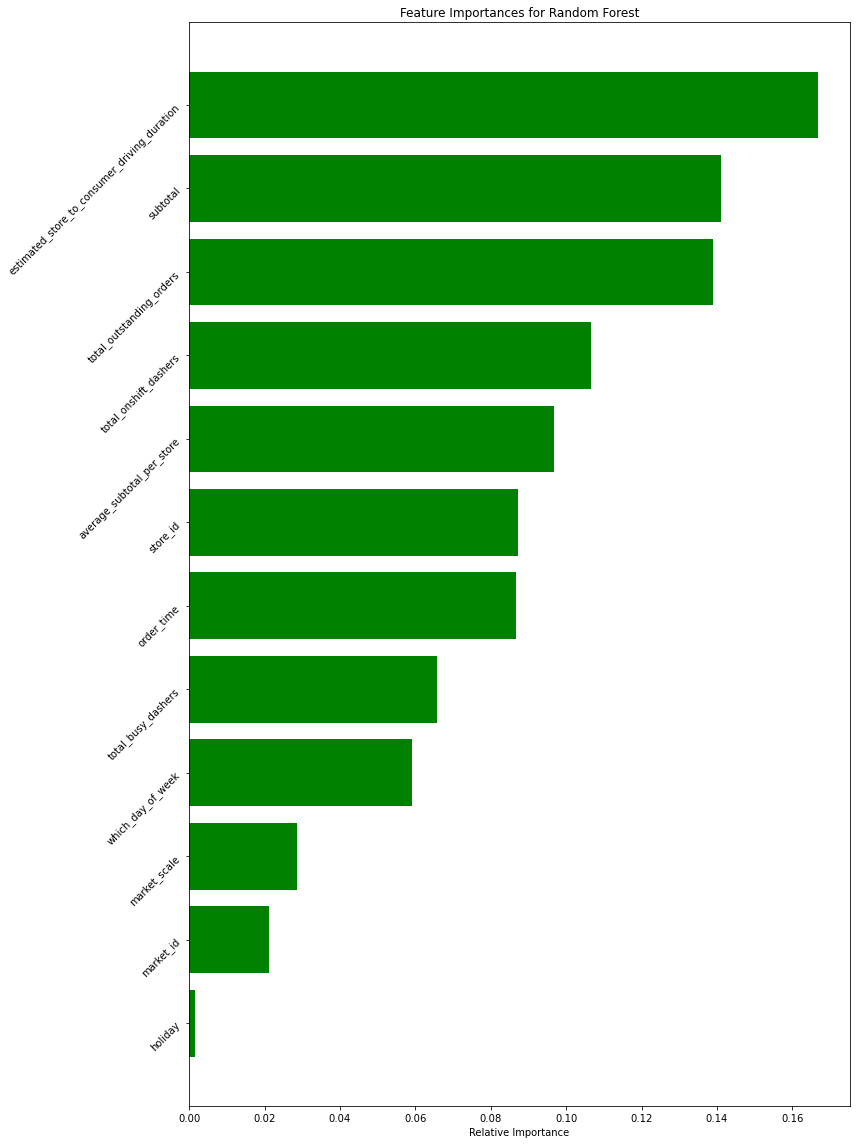

In [49]:
%%time
y_pred_rf, y_test_rf = delivery_rf_evaluate(infeature, y) 

### XGBoost Algorithm<a name="xgboost"></a>

XGBoost, as a gradient boosting library, in most cases can outperform the random forest model. Nevertheless, the downside of the method is that it can be **really difficult to find a optimal combination of the hyperparameters that we want to work with**. Here, we want to "naively" use the algorithm to see by how much we could improve the prediction performance, when comparing to the random forest model.

#### Step 1: Hyperparameter Tuning for XGBoost<a name="hyper_xgboost"></a>

Due to the **computing resources on a local desktop**, we have to limit ourselves to only a very rough model of the hyperparameter tuning process. 

In [54]:
def delivery_xgb_hyperparam_depth_nest(X, y):
    #Defining the scoring metrics
    scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error']

    #Data partitioning into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40) 
    
    #fit Random Forest model
    xg = xgb.XGBRegressor(objective='reg:squarederror') 
    cv = RepeatedKFold(n_splits=5, n_repeats=1)
    
    # ---------- This part was for hyperparameter tuning -------------------
    
    #define grid
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 120, stop = 150, num = 10)]
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
    max_depth.append(None)
    # Minimum number of samples to create a new node in the tree: small number tend to overfit
    min_child_weight = [int(x) for x in np.arange(5, 10, 1)]
    # fraction of features (the columns) to use
    colsample_bytree = [i/10. for i in range(5,11)]

    
    #Create the random grid
    random_grid = {'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_child_weight': min_child_weight,
                    'colsample_bytree': colsample_bytree
                   }
    #perform the search
    xg_random = RandomizedSearchCV(estimator = xg, \
                               param_distributions = random_grid, n_iter = 5, \
                               cv = cv, verbose=1, random_state=42, n_jobs = -1, \
                                   return_train_score=True, scoring=scoring,
                                  refit='neg_mean_absolute_error')

    results = xg_random.fit(X_train, y_train)
    # summarize
    print('neg-MAE: %.3f' % results.best_score_)
    print('Config: %s' % results.best_params_)

    # ---------- hyperparameter tuning end here -------------------
    
    model_best = results.best_estimator_.fit(X_train, y_train)
    cv_scores = cross_validate(model_best, X, y, scoring=scoring,
                         cv=cv, return_train_score=True)
    y_pred = model_best.predict(X_test)

    print_sklearn(model_best, X_train, y_train, X_test, y_test, y_pred, cv_scores)
    
    ## predict train set  (in-sample)
    in_forecast = model_best.predict(X_train)
    print(run_error_result(y_test, y_pred,'Test data'))
    print(run_error_result(y_train, in_forecast,'Training data'))
    return 0

In [55]:
delivery_xgb_hyperparam_depth_nest(infeature, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


neg-MAE: -652.990
Config: {'n_estimators': 150, 'min_child_weight': 5, 'max_depth': None, 'colsample_bytree': 0.9}
ML Library: 

 Training -------------------

 R2 value(training): 0.449

 Cross validation scores:
 R2 (training) values:
[0.43490422 0.42832397 0.4317355  0.4222788  0.42787197]
 neg-mean-absolute-error (training) values:
[-597.23174811 -597.0208082  -598.99338284 -599.84225586 -598.46231884]
------------------------------------


 Testing -------------------

 R2 value(testing): 0.310

 Cross validation scores:
 R2 (testing) values:
[0.29817016 0.31868724 0.31524875 0.3196924  0.3014976 ]
 neg-mean-absolute-error (testing) values:
[-646.72909475 -638.87991568 -642.45505643 -640.44978775 -642.53224327]
 Mean squared error: 905262.81
 Root Mean squared error: 951.45
 Mean absolute error 646.66
 Mean absolute percentage error 0.24
------------------------------------

                  MAE      MAPE        RMSE
Test data  646.664425  0.241007  951.452998
                   

0

#### Step 2: Evaluation using the Optimal XGBoost Model<a name="eval_xgboost"></a>

In [56]:
def delivery_xg_evaluate(X, y):
    #Defining the scoring metrics
    scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error']

    #Data partitioning into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40,random_state=0) 
    
    #fit XGBoost model
    cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=0)
    xg = xgb.XGBRegressor(objective='reg:squarederror',
                          n_estimators= 150, max_depth= None,
                          min_child_weight= 5, colsample_bytree= 0.9
                          ) 
    
    results = xg.fit(X_train, y_train)
    y_pred = results.predict(X_test)
    
    cv_scores = cross_validate(xg, X, y, scoring=scoring,
                         cv=cv, return_train_score=True)

    print_sklearn(xg, X_train, y_train, X_test, y_test, y_pred, cv_scores)
    
    ## predict train set  (in-sample)
    in_forecast = xg.predict(X_train)
    print(run_error_result(y_test, y_pred,'Test data'))
    print(run_error_result(y_train, in_forecast,'Training data'))
    return y_pred, y_test

In [62]:
%%timeit
y_pred_xg, y_test_xg = delivery_xg_evaluate(infeature, y)

ML Library: 

 Training -------------------

 R2 value(training): 0.444

 Cross validation scores:
 R2 (training) values:
[0.41998686 0.42401406 0.41661958 0.42026854 0.41672053 0.42271214
 0.42079321 0.42878399 0.42210584 0.41662231]
 neg-mean-absolute-error (training) values:
[-602.06021319 -600.99657937 -601.57467004 -600.76027607 -602.15838891
 -600.41892381 -599.41027819 -597.66235327 -600.31449935 -601.47296107]
------------------------------------


 Testing -------------------

 R2 value(testing): 0.319

 Cross validation scores:
 R2 (testing) values:
[0.31461798 0.33636825 0.33218796 0.34771881 0.35489559 0.32556006
 0.29476146 0.24915394 0.29892416 0.32525507]
 neg-mean-absolute-error (testing) values:
[-638.15524135 -637.65604352 -641.66544245 -636.30278936 -625.63755511
 -638.59962577 -647.15842585 -652.91455788 -646.57386187 -641.1466166 ]
 Mean squared error: 869673.01
 Root Mean squared error: 932.56
 Mean absolute error 645.22
 Mean absolute percentage error 0.24
------

               MAE      MAPE        RMSE
Test data  645.215  0.240982  932.562604
                      MAE      MAPE        RMSE
Training data  594.562085  0.221371  884.972485
ML Library: 

 Training -------------------

 R2 value(training): 0.444

 Cross validation scores:
 R2 (training) values:
[0.41998686 0.42401406 0.41661958 0.42026854 0.41672053 0.42271214
 0.42079321 0.42878399 0.42210584 0.41662231]
 neg-mean-absolute-error (training) values:
[-602.06021319 -600.99657937 -601.57467004 -600.76027607 -602.15838891
 -600.41892381 -599.41027819 -597.66235327 -600.31449935 -601.47296107]
------------------------------------


 Testing -------------------

 R2 value(testing): 0.319

 Cross validation scores:
 R2 (testing) values:
[0.31461798 0.33636825 0.33218796 0.34771881 0.35489559 0.32556006
 0.29476146 0.24915394 0.29892416 0.32525507]
 neg-mean-absolute-error (testing) values:
[-638.15524135 -637.65604352 -641.66544245 -636.30278936 -625.63755511
 -638.59962577 -647.15842585 

### Model Comparison<a name="model_comp"></a>

As suggested in the problem description, "*order lateness / underprediction of delivery time is of particular concern as past experiments suggest that underestimating delivery time is roughly twice as costly as overestimating it. Orders that are **very early / late are also much worse than those that are only slightly early / late**.*" It is understandable that no model can predict delivery time perfectly (up until this point). Hence, when comparing the performance of the different models, focus was drawn onto the percentage of **slightly (within 10 mins difference)** vs. **very (larger than 10 mins difference)** late / early predictions.  

Therefore, We want to **find a model that has the largest percentage of slightly early / late predictions and lower the risks of giving predictions that are really off.**

slightly late     30.452670
very late         28.154403
slightly early    20.925656
very early        20.467272
Name: lr_prediction_accuracy, dtype: float64
<-------------------------------->
slightly late     30.448860
very late         28.148054
slightly early    20.943432
very early        20.459653
Name: lasso_prediction_accuracy, dtype: float64
<-------------------------------->
slightly late     33.519142
very late         25.533617
slightly early    21.909720
very early        19.037521
Name: random_forest_prediction_accuracy, dtype: float64
<-------------------------------->
slightly late     34.433369
slightly early    23.805473
very late         23.221383
very early        18.539775
Name: xgboost_prediction_accuracy, dtype: float64
<-------------------------------->


<AxesSubplot:>

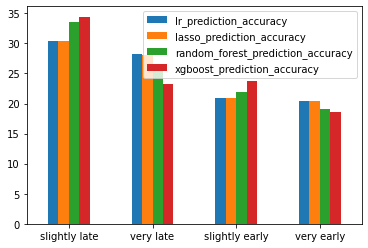

In [58]:
df_lr = early_or_late(y_pred_lr, y_test_lr, 'lr')
df_lasso = early_or_late(y_pred_lasso, y_test_lasso, 'lasso')
df_lr_lasso = pd.concat([df_lr, df_lasso], axis=1)
df_rf = early_or_late(y_pred_rf, y_test_rf, 'random_forest')
df_lr_lasso_rf = pd.concat([df_lr_lasso, df_rf], axis=1)
df_xg = early_or_late(y_pred_xg, y_test_xg, 'xgboost')
df_all_model = pd.concat([df_lr_lasso_rf, df_xg], axis=1)
df_all_model.plot.bar(rot=0)
plt.savefig("method_comparison.png")

From the bar plot shown in the cell above, we could see that overall, Lasso regression and regular linear regression models have pretty similar performances, with the higher percentages, at **~50% level** combined, of **very late** and **very early** predictions, comparing to the random forst and xgboost algorithm. The mean-absolute-error (MAE) metric of these two models (printed ealier in the notebook), both give values of **~718 seconds, or ~12 minutes** of difference between the actual and predicted values, which is considered to be a **very** late / early prediction. 

The Random Forest model reduces the orders greater than 10 minutes late / early by **more than 5% (comparing to the linear regression models)**, with a MAE value of ~670 seconds, or ~11 minutes. This can be considered as a significant improvement as we decrease the amount of "disastrous" predictions by 10%.

XGBoost has the capability of providing further higher rates of slightly different predictions, giving a only **~40% bad predictions** and **60% predictions that are considered only slightly off**, with a even smaller MAE value of **~645 seconds, or less than 11 minutes, difference** between the actual and the predicted values. 

Therefore, when predicting the test set values, we decide to go with the XGBoost model that we developed:

## Test Set Predictions<a name="test_pred"></a>

In [59]:
def test_set_pred(X, y, df_test):
    nocreate = df_test.loc[:, df_test.columns != "created_at"]
    matched_cols = nocreate.loc[:, nocreate.columns != "delivery_id"]
    #fit XGBoost model
    cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=0)
    xg = xgb.XGBRegressor(objective='reg:squarederror',
                          n_estimators= 150, max_depth= None,
                          min_child_weight= 5, colsample_bytree= 0.9
                          ) 
    
    results = xg.fit(X, y)
    df_test["predicted_delivery_duration"] = results.predict(matched_cols)
    return df_test[['delivery_id','predicted_delivery_duration']]

In [60]:
df_pred_final = test_set_pred(infeature, y, df_test)
df_pred_final.head()

,delivery_id,predicted_delivery_duration
0,194096,4011.081055
1,236895,3127.365479
2,190868,3756.062988
3,183076,3560.550537
4,186200,2440.060791


In [61]:
df_pred_final.to_csv('data_to_predict.csv')